Precompute separate log signatures for each of the highlited brain regions:

<img src="../images/brain_regions.png" style="width: 200px;"/>

In [1]:
import numpy as np
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from signature_transform_utils import modify_metadata, preprocess_for_sig, calculate_logsignature_for_metadata, calculate_signature_for_metadata, butter_bandpass_filter
import signatory
import torch

/home/barbora/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
TRAIN_EEG_DIR = "../../data/train_eegs/"
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"

In [3]:
train_metadata = pd.read_csv(TRAIN_METADATA_DIR)
train_metadata = modify_metadata(train_metadata)

In [4]:
train_metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,9.0,9.0,20654,Other,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,18.0,18.0,20230,LPD,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,12.0,1020.0,5955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,0.0,908.0,38549,GPD,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0.0,0.0,40955,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,1549502620,0.0,0.0,15065,GRDA,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,2105480289,0.0,0.0,56,Other,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,657299228,6.0,6.0,4312,Other,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [5]:
preprocessed = preprocess_for_sig(train_metadata.head(10), TRAIN_EEG_DIR, scaler_type="meanvar_0.2")

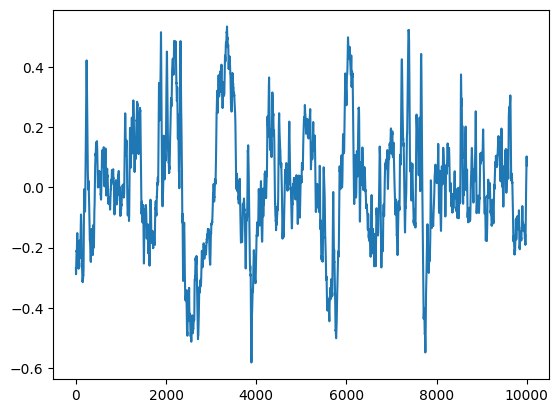

In [6]:
# example of a preprocessed eeg signal
plt.plot(preprocessed[1,:,4])

In [16]:
scaler_types = ["meanvar_1.0"]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
def calculate_and_store_sigs(scaler_type):
    """Calculate and store signatures up to level 6 for the given scaler type"""
    calculate_signature_for_metadata(train_metadata, TRAIN_EEG_DIR, TRAIN_SIGNATURES_DIR, scaler_type = scaler_type, batch_size=1000, device=device, level=6)
    for i in range(0, len(train_metadata), 1000):
        sigs = torch.load(f"{TRAIN_SIGNATURES_DIR}sigs_lvl_6_scaler_{scaler_type}_{i}.pt")
        if i == 0:
            all_sigs = sigs
        else:
            all_sigs = torch.cat((all_sigs, sigs), 0)
    torch.save(all_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_6_scaler_{scaler_type}.pt")
    print(f"Done with {scaler_type}")

In [13]:
for scaler_type in scaler_types:
    calculate_and_store_sigs(scaler_type)

Processed 0 records.
Processed 1000 records.
Processed 2000 records.
Processed 3000 records.
Processed 4000 records.
Processed 5000 records.
Processed 6000 records.
Processed 7000 records.
Processed 8000 records.
Processed 9000 records.
Processed 10000 records.
Processed 11000 records.
Processed 12000 records.
Processed 13000 records.
Processed 14000 records.
Processed 15000 records.
Processed 16000 records.
Processed 17000 records.
Done with meanvar_1.0


In [8]:
# also store level 5, 4, 3
sig_5_dim = signatory.signature_channels(5, 5)
sig_4_dim = signatory.signature_channels(5, 4)
sig_3_dim = signatory.signature_channels(5, 3)

In [18]:
for scaler_type in scaler_types:
    lvl_6_sigs = torch.load(f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_6_scaler_{scaler_type}.pt")
    lvl_5_sigs = lvl_6_sigs[:,:,0:sig_5_dim]
    lvl_4_sigs = lvl_6_sigs[:,:,0:sig_4_dim]
    lvl_3_sigs = lvl_6_sigs[:,:,0:sig_3_dim]
    torch.save(lvl_5_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_5_scaler_{scaler_type}.pt")
    torch.save(lvl_4_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_4_scaler_{scaler_type}.pt")
    torch.save(lvl_3_sigs, f"{TRAIN_SIGNATURES_DIR}all_sigs_lvl_3_scaler_{scaler_type}.pt")
    print(f"Done with {scaler_type}")

Done with meanvar_1.0
